# Group Assignment 1 - Benchmarking Game of Life

In this assignment, we compared the parallel computation of Conway’s Game of Life with the non-parallel computing. We use Dask which is a python library for implementing parallel computing.

We wrote game_dask.py (implemented game using Dask) and game_nodask.py (implemented game without using Dask) and compared how several parameters affects the way the games are processed. We executed both versions of the game using several profilers. We also compared several grid sizes and generations to arrive to a conclusion on how both parameters affects the game performance.

The cell below shows the code for Conway's Game of Life implementation - both with and without Dask.

In [ ]:
import sys
import numpy as np
import dask.array as da
import time
from dask.distributed import Client


# Read grid from input file
def read_input(filename):
    with open(filename) as f:
        
        # Read only the first line for the dimension
        w, h = map(int, f.readline().split())
        
        # Read the rest of the input file to build the whole grid
        # Create all 0
        grid = []
        for y in range(h):
            grid.append([0] * w)
        
        # Create all alive cells
        for line in f:
            y, x = map(int, line.split())
            grid[y][x] = 1
        
        # Convert the grid into Numpy array
        grid = np.array(grid)
    return grid


# Create a function that counts alive cells in neighborhood of any arbitraty cell
def countlive(grid, x, y, w, h):
    
    # Generate an array based on relative locations of neighboring cells
    nb = np.array([
        (-1, -1), (-1, 0), (-1, 1),
        (0, -1),           (0, 1),
        (1, -1),  (1, 0),  (1, 1)
    ])
    
    # Count the alive cells
    alive = 0
    for dx, dy in nb:
        nx, ny = x + dx, y + dy
        if 0 <= nx < w and 0 <= ny < h and grid[ny][nx]==1:
            alive += 1

    return alive


# The rule application in one generation of the game
def tick(grid):
    h = len(grid)
    w = len(grid[0])
    
    newgrid = np.array([[0] * w for _ in range(h)])

    for y in range(h):
        for x in range(w):
            live_nb = countlive(grid, x, y, w, h)

            # Applying Game of Life rules based on the number s of neighboring cells
            if grid[y][x] == 1:
                if live_nb == 2 or live_nb == 3:
                    newgrid[y][x] = 1
            else:
                if live_nb == 3:
                    newgrid[y][x] = 1

    return newgrid


# Determine the dimensions of the grid
def grid_size(inputfile):
    width = len(inputfile[0])
    height = len(inputfile)
    return width, height


# Creating a function to write the resultant grid in output file
def save_output(grid, output):
    with open(output, "w") as f:
        
        # Using grid_dims function to capture grid size info
        w, h = grid_size(grid)
        f.write(f"{w} {h}\n")

        # Writing the grid size info in the output
        # Write the alive cells only
        for y, row in enumerate(grid):
            for x, cell in enumerate(row):
                if cell == 1:
                    f.write(f"{y} {x}\n")

                    
# Run the game for specified amount of generation
def tickrun(input, output, generation):
    grid = read_input(input) 
    
    for gen in range(generation):
        grid = tick(grid)
        
    save_output(grid, output)
    return grid


# Run the game for specified amount of generation using Dask
def daskrun(input, output, generations, chunk):
    
    grid = read_input(input) 
    grid_dask = da.from_array(grid, chunks = (chunk[0], chunk[1]))
    
    for gen in range(generations):
        grid_dask = grid_dask.map_overlap(
            tick, depth=1, boundary="none"
        )
    
    grid = grid_dask.compute()
    
    save_output(grid, output)
    return grid

In [ ]:
# For Dask computing. Change the parameters accordingly.
if __name__ == "__main__":
    input = "./bench/1000x1000_0.2.txt"
    output = "./bench/dask_1tick_1k.txt"
    generation = 1
    chunk = [100,100]
    mainrun = daskrun(input, output, generation, chunk)

print(mainrun)

In [ ]:
# For Non-Dask computing. Change the parameters accordingly.
if __name__ == "__main__":
    input = "./bench/1000x1000_0.2.txt"
    output = "./bench/nodask_1tick_1k.txt"
    generation = 1
    mainrun = tickrun(input, output, generation)

print(mainrun)

Below are the exploration results and steps in the benchmarking and comparation process.

## CPU and Wall Time

In this section, we compared Dask along with its scheduler options with non-Dask implementation of the game by observing CPU and wall time.

We ran both versions for 1,000 x 1,000 with 20% initial alive cells and 10,000 x 10,000 with 50% initial alive cells to see how grid sizes affect CPU time (The time the CPU spends actively processing a program's instructions) and Wall time (the actual time that elapses from the start to the end of a task, including all delays) for each computations. We ran both versions for 1 generation only.

For Dask version, we ran through four different schedulers: Distributed, Threads, Processes, and Synchronous - and compared the CPU and wall time each takes to finish the processing. For both grid sized, we tried to use 100x100 chunk size for the computation at first and found that this size finished in plausible duration (not too long) and continued using this size for the whole assignment.

For non-Dask version, we simply ran for both the grid sizes and measure the CPU and wall time.

Table below shows the time measured for each versions of computations.

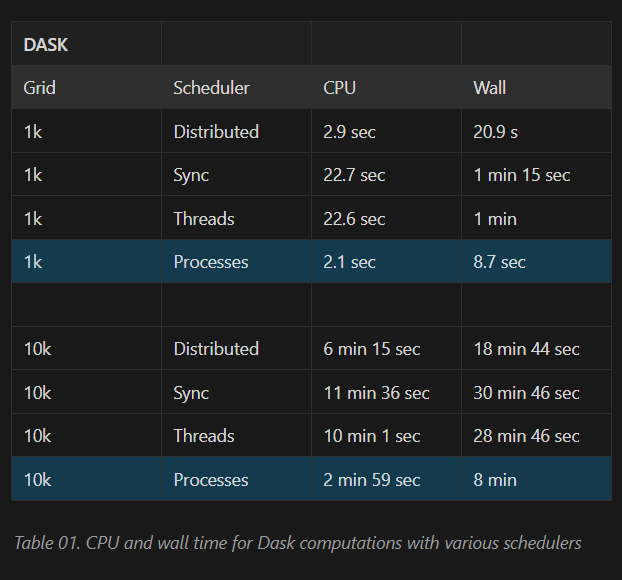

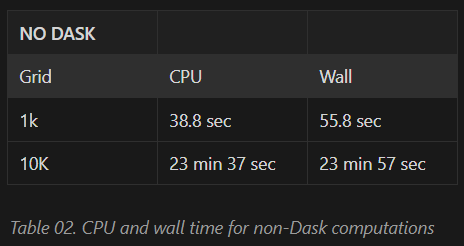

From the CPU and wall time of each schedulers, Processes scheduler performed the best time. This is due to this scheduler supports true parallelism to execute tasks that heavily use CPU. This advantage is unlike other schedulers like Threads that still have some limitations to achieve true parallelism such as Global Interpreted lock (GIL) in the Python itself. This might be the reason Threads scheduler shows in relatively much longer CPU time than Processes despite both supports multiple threads to do tasks concurrently. This might even explains why Threads scheduler’s CPU time is almost similar to the Synchronous scheduler which sets Dask to operates within a single thread or execution and runs tasks in sequential order.

It is also interesting to observe that Distributed scheduler has similar CPU time to Processes scheduler’s but took longer wall time. This might because Distributed scheduler introduced additional overhead for communicating the tasks between workers, while Processes scheduler has advantages over shared worker memory and more efficient data transfer.

On the other hand, game_nodask.py uses no Dask distributed computation which means it is less efficient and has limited parallel computing compared to game_dask.py. This explains why non-Dask computations typically take more time than Dask computations. In this assignment, meanwhile, it is interesting to see that both Synchronous and Threads schedulers actually took longer time to compute our Game of Life than non-Dask implementation. This might be that the overhead to have multiple processing in both mentioned schedulers makes one generation of Game of Life took longer that to run one generation normally. This shows that parallel computing does not mean better for all kind of tasks, especially simple tasks that not even need such overkill processing to complete.

## C Profiler

In this section, we compared parallel and non-parallel computing with cProfile. The purpose of using cProfile is to identify bottlenecks to know how much time is spent in different parts of the code.

We compared Processes-scheduler Dask computing (the fastest scheduler for Dask in this assignment explained in the previous section) and non-Dask computing for 1,000x1,000 grid size with several generations. This helped us to see how effective parallel computing in processing CPU-consuming tasks.

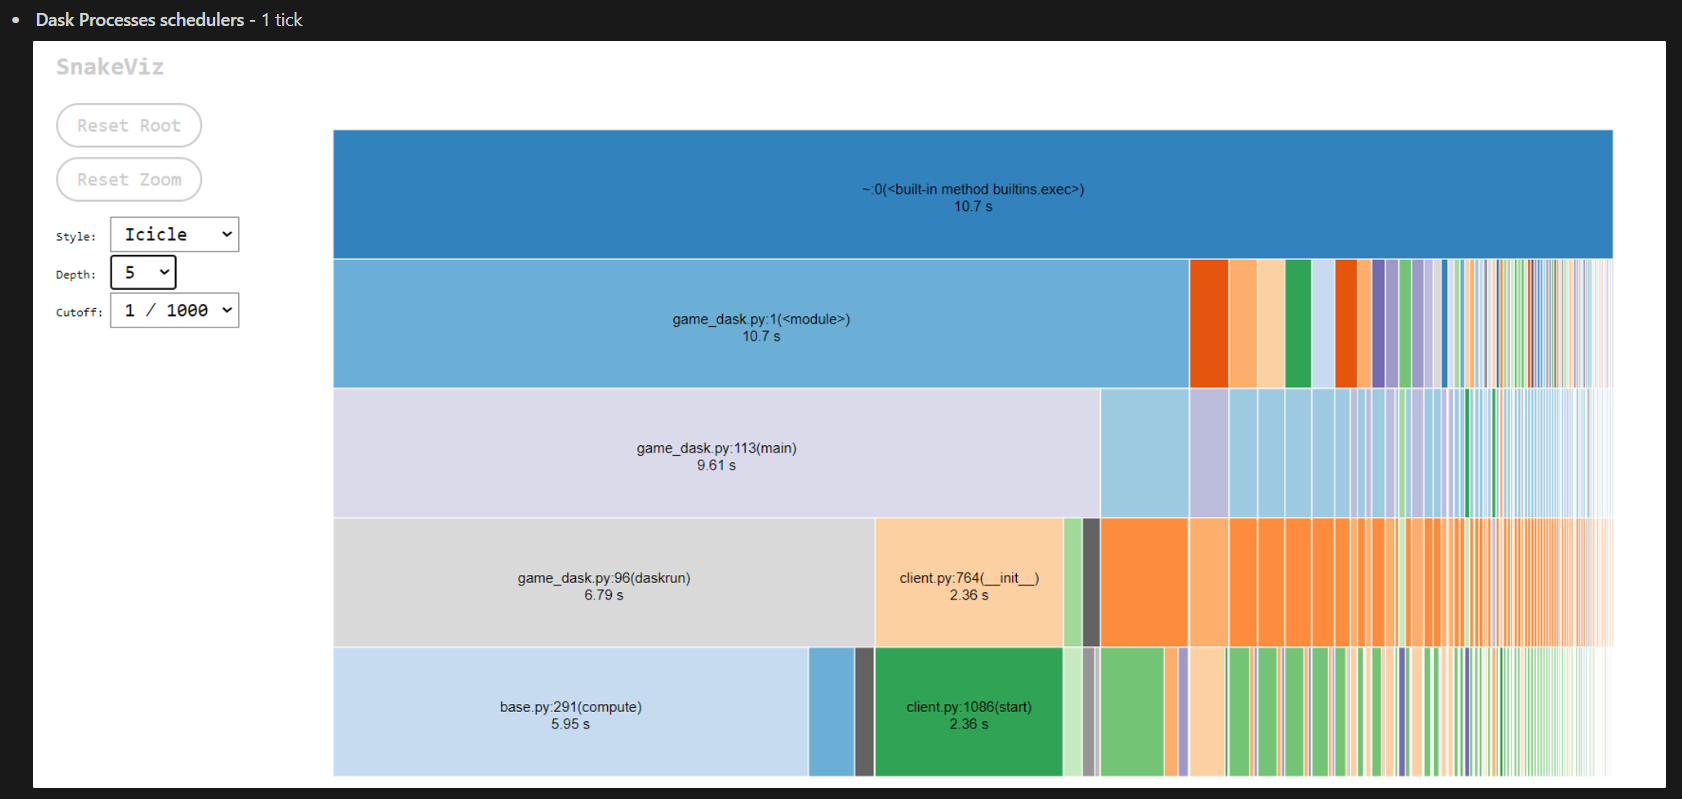

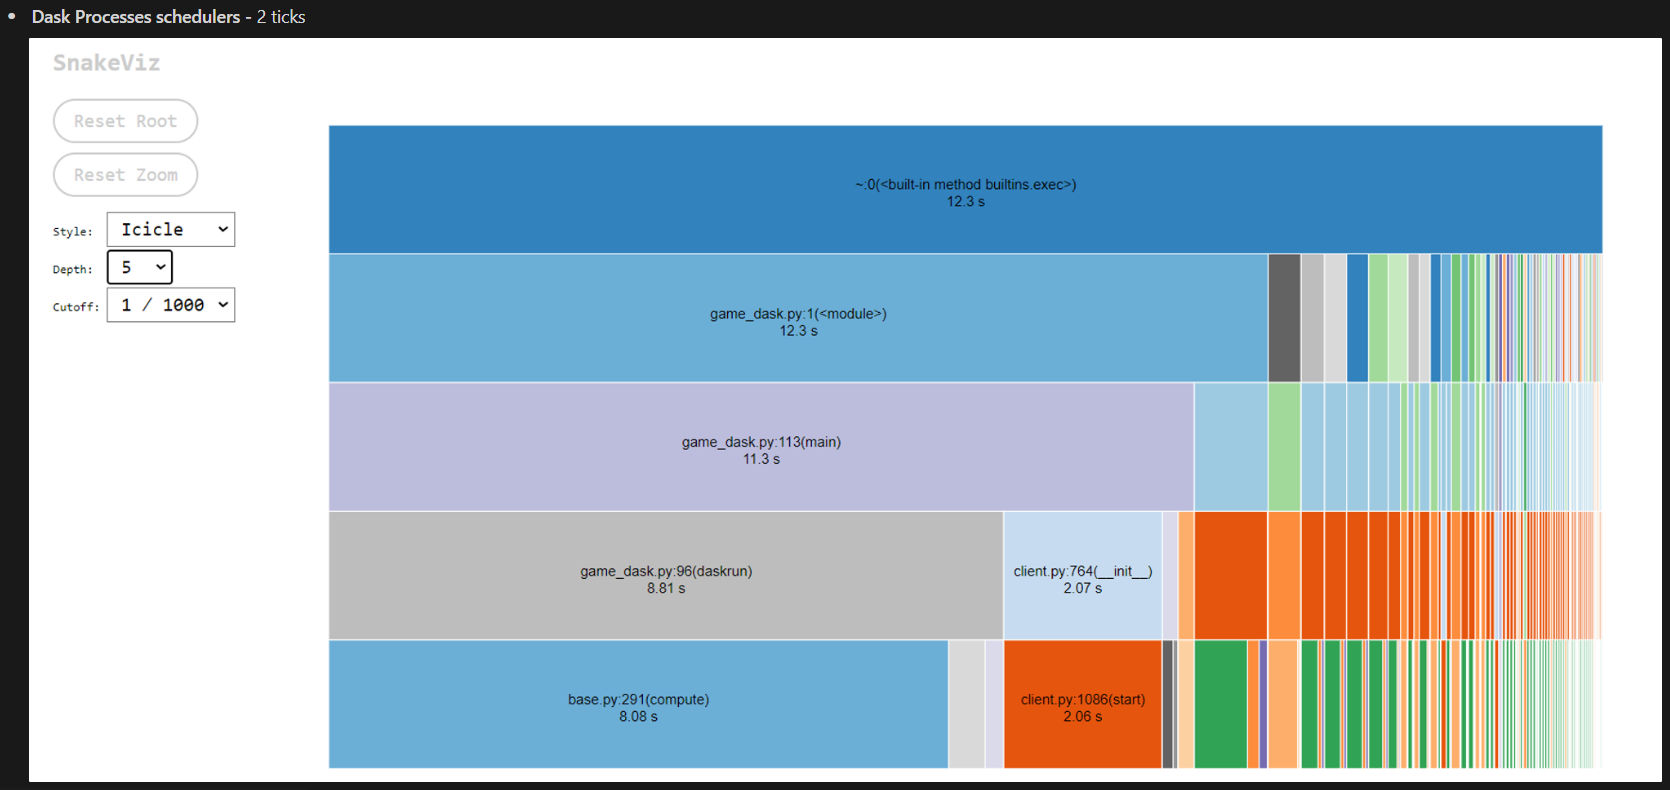

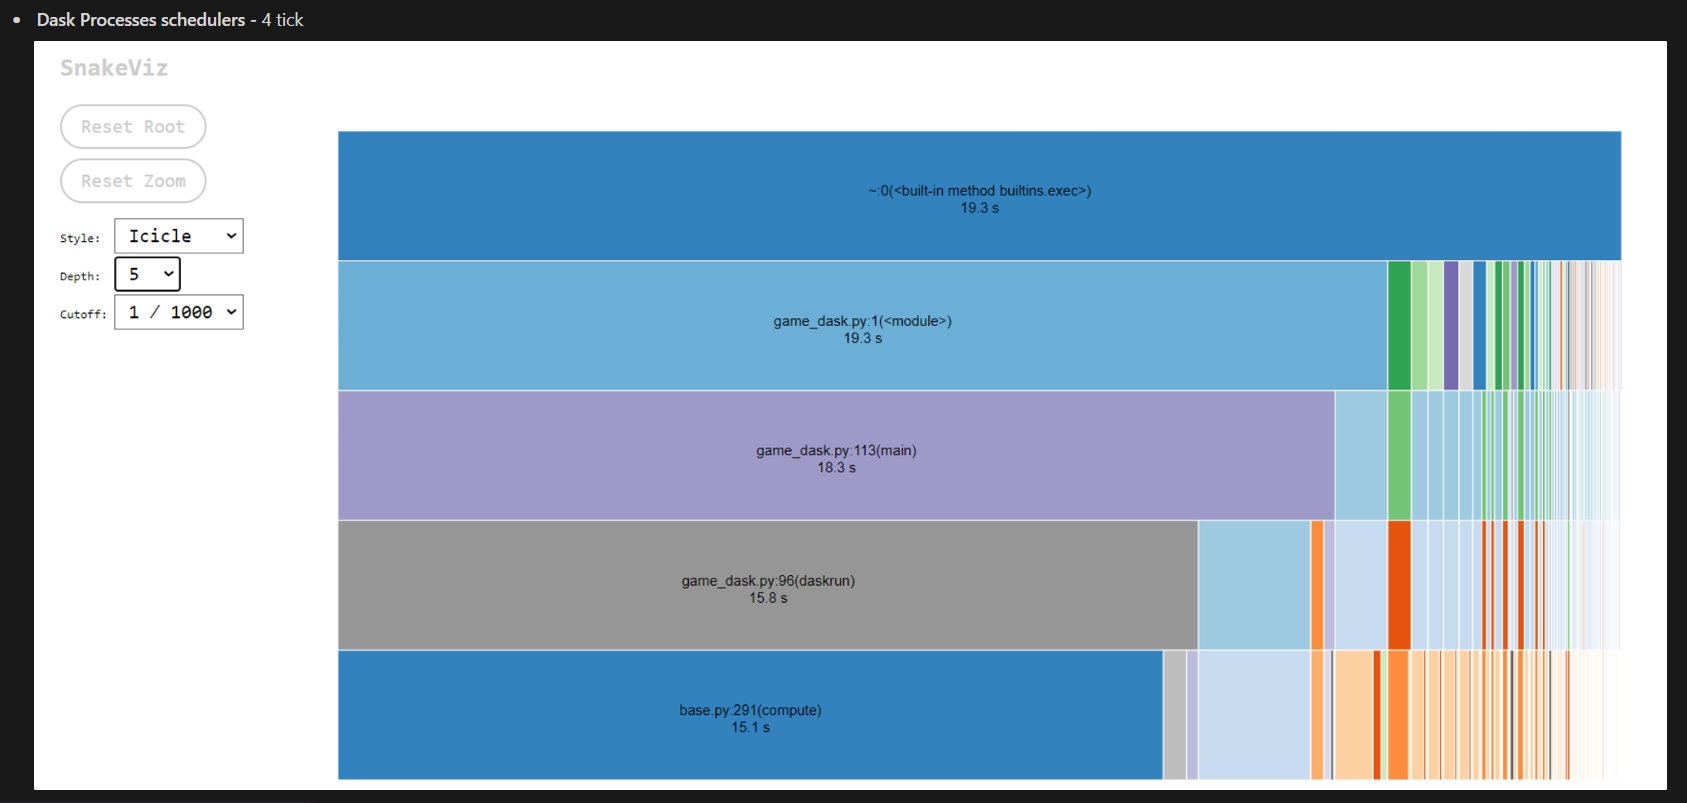

The pictures above are the observed cProfile images for each generations in Dask computing. We can see that Dask computing is effective in suppressing time for bigger generations compared to non-Dask implementation. For 1, 2, and 4 generations of Game of Life in Dask, respectively the consumed time were 10, 12, and 19 seconds.

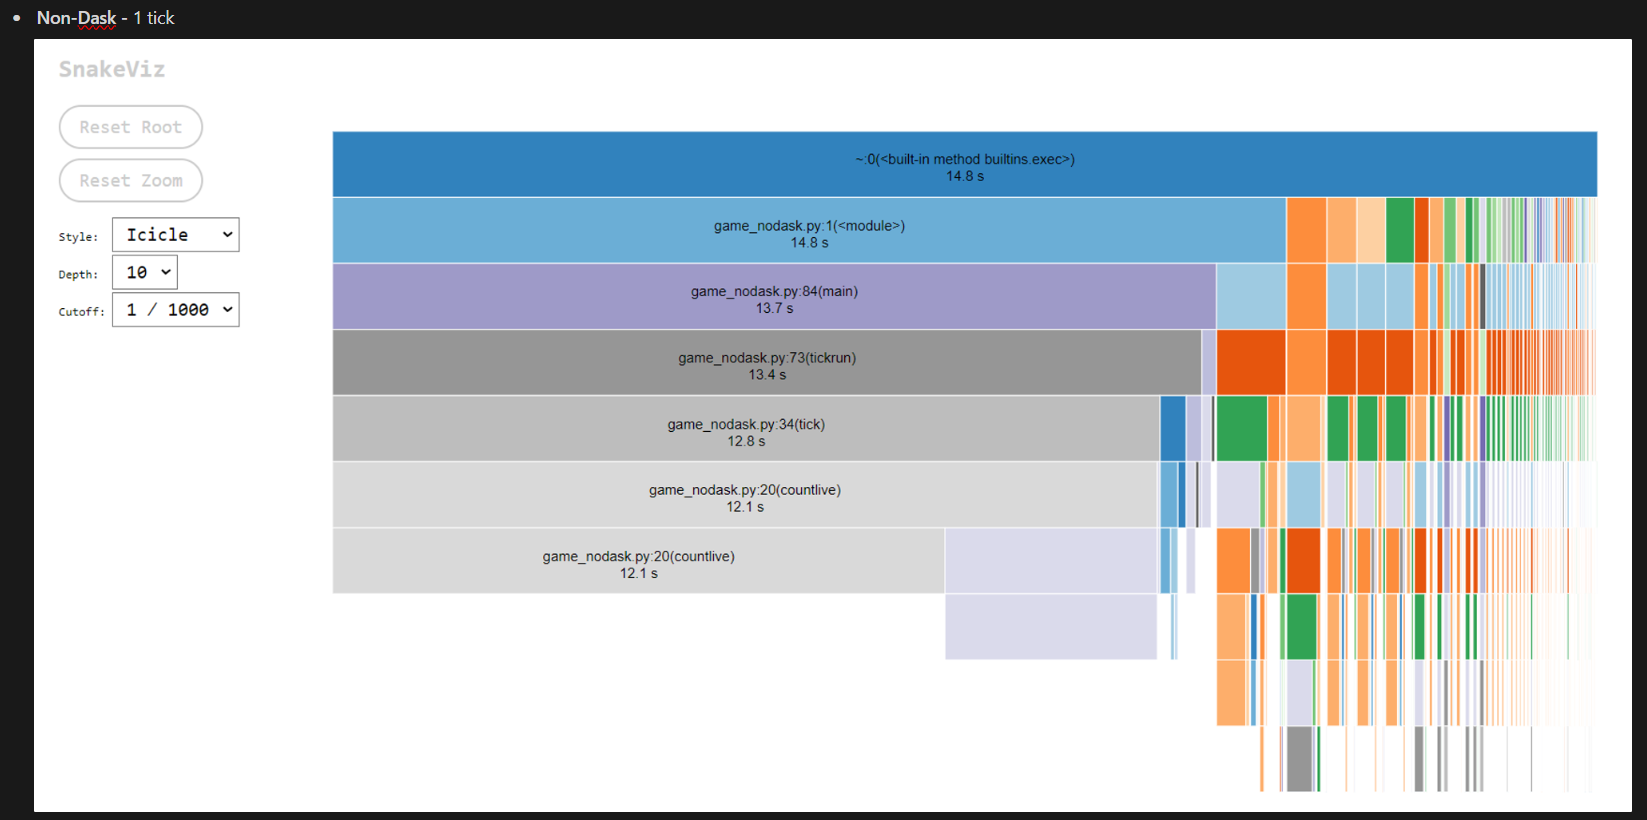

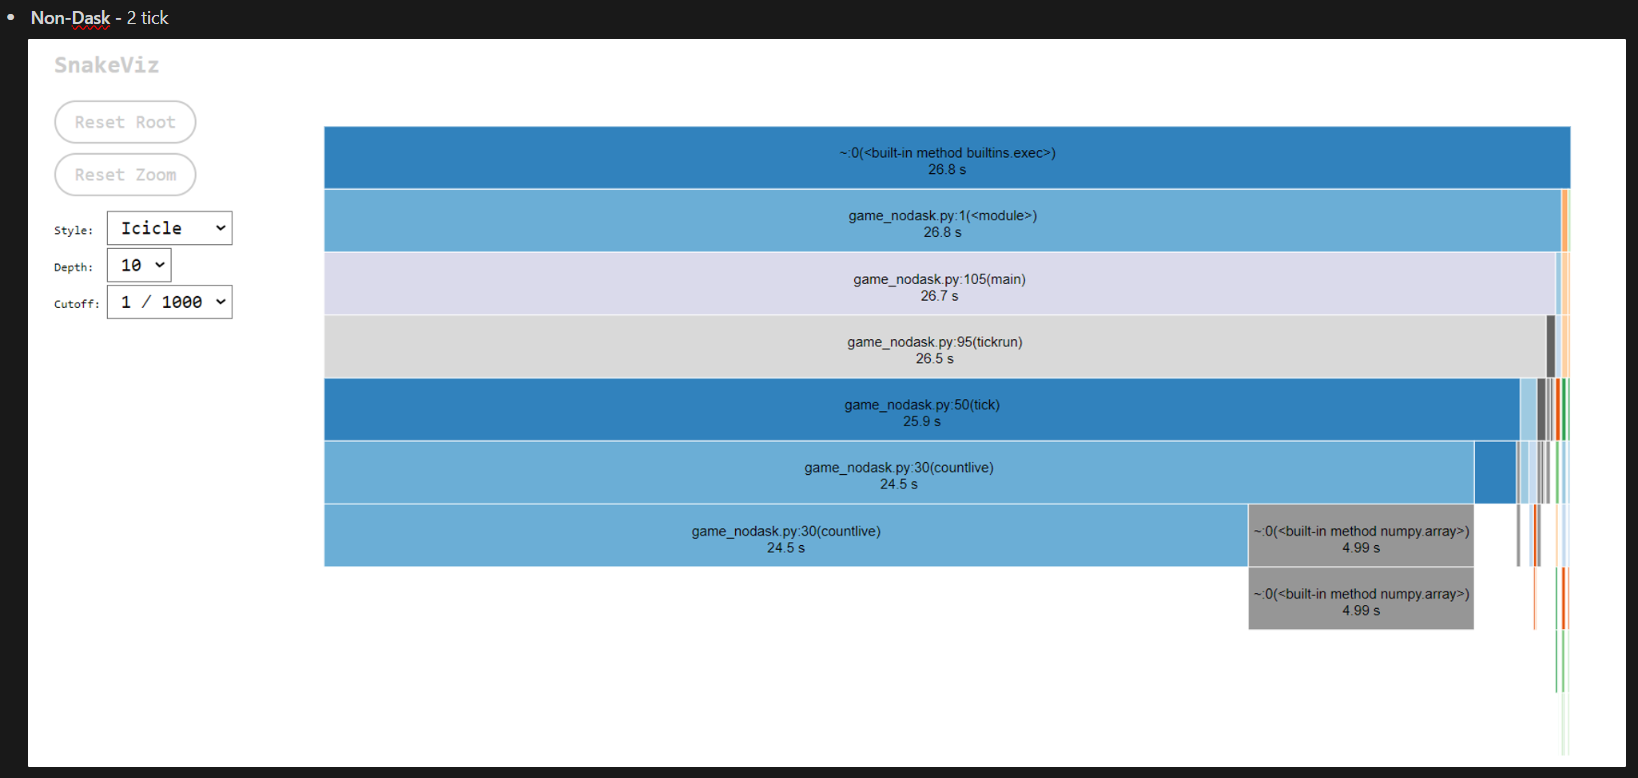

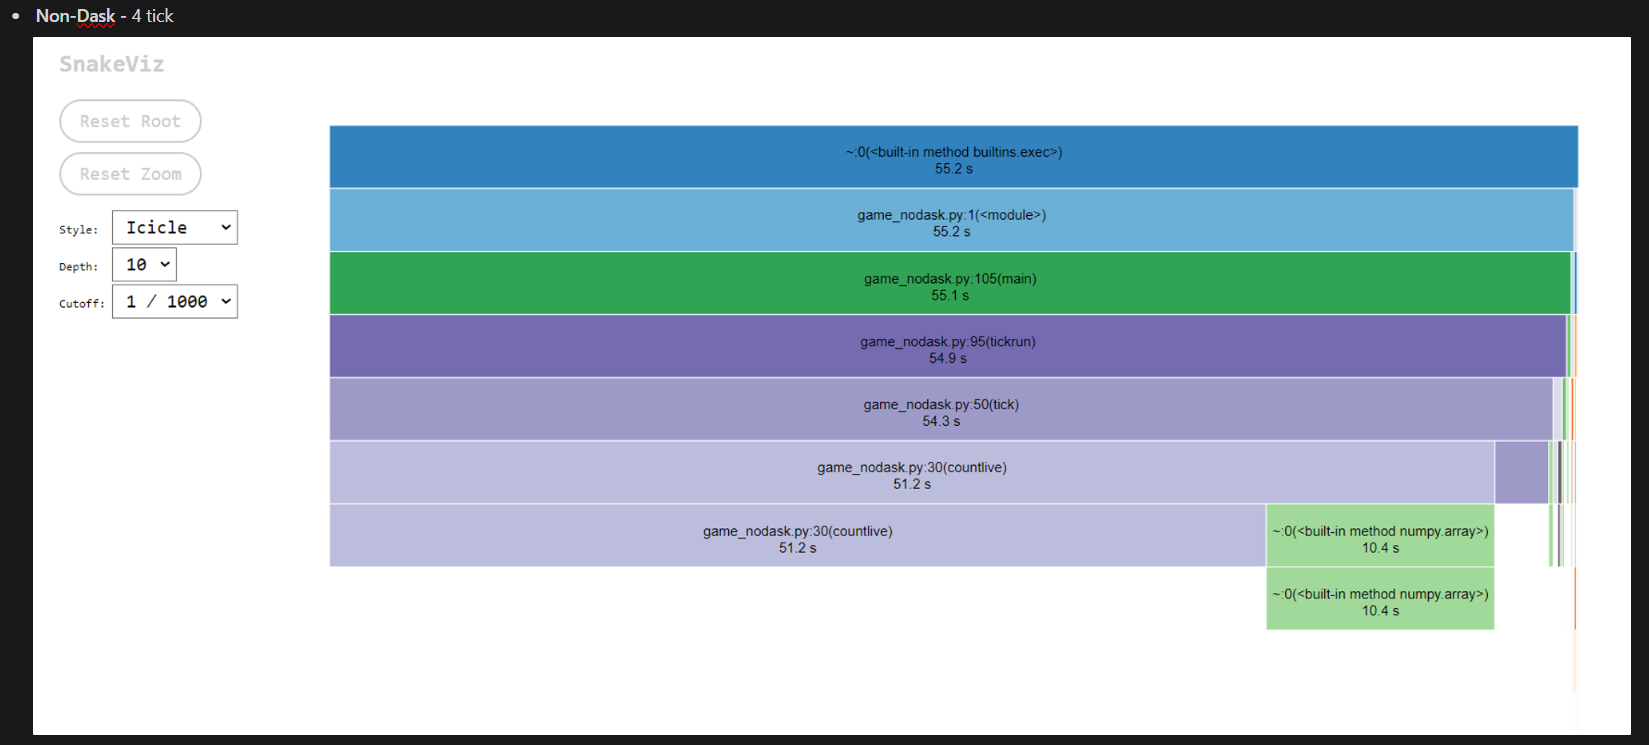

Meanwhile as seen above, non-Dask implementations almost double the time for every mentioned generation changes — with 14, 26, and 55 seconds. These particular examples show non-parallelism in processing game_nodask.py and emphasize the effectiveness of Dask in reducing computing time for bigger tasks.

From all cProfile above, we can see that aside of Python built-in method and module imports, main becomes the biggest time-consuming part of the code. This makes sense as the main part of the code executes all other functions contained in the code as we can see from the nested nature shown from the snakeviz itself.

Inside main, both Dask and non-Dask implementation has respectively daskrun and tickrun as the biggest functions that follows the main execution. Both are the functions that contains all other codes to run the Game of Life itself which explain how time-consuming in relative to other nested functions.

In Dask version, we can see that compute as the next most time-consuming function since it is the part of the code that triggers the whole operations to return something. Meanwhile in the non-Dask version, tickrun is followed by tick function as the next biggest function.

## Line Profiler

In this section, we dived deeper in analyzing each line of specified functions using Line Profiling. The purpose of using Line Profiling technique and comparing the profile of functions are to provide in-depth performance analysis of different functions and sections of the code.

From both Processes-scheduler Dask computing and non-Dask computing for generating one Game of Life with 1,000x1,000 grid size, we compare read_input, save_output, and daskrun/tickrun respectively. These specific selections are to see how effective the code for each input reading, processing, and output writing by pinpointing the lines of codes that consumed the most resource and time.

This helped us to gain insights about the behavior of different functions in our code.

Below are the Line Profiling for each mentioned functions from game_dask.py.

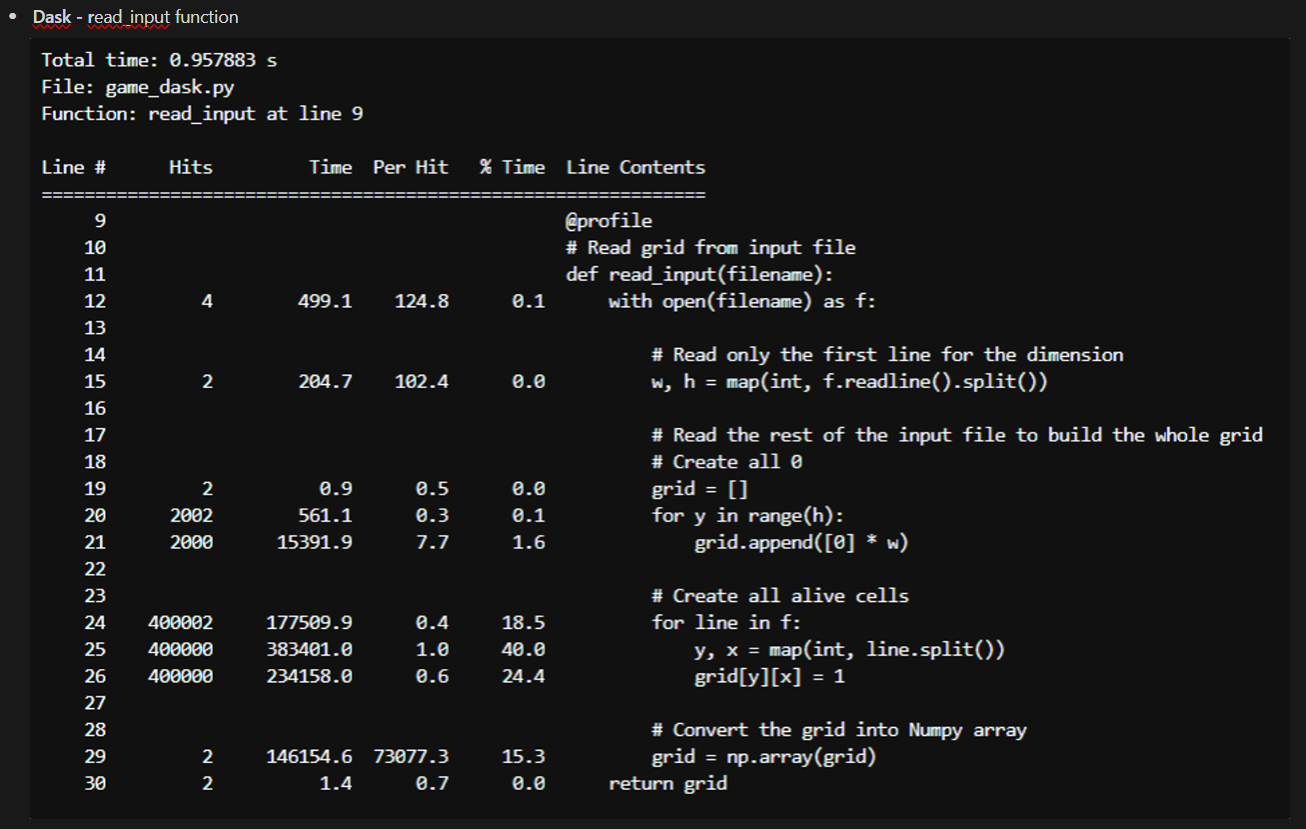

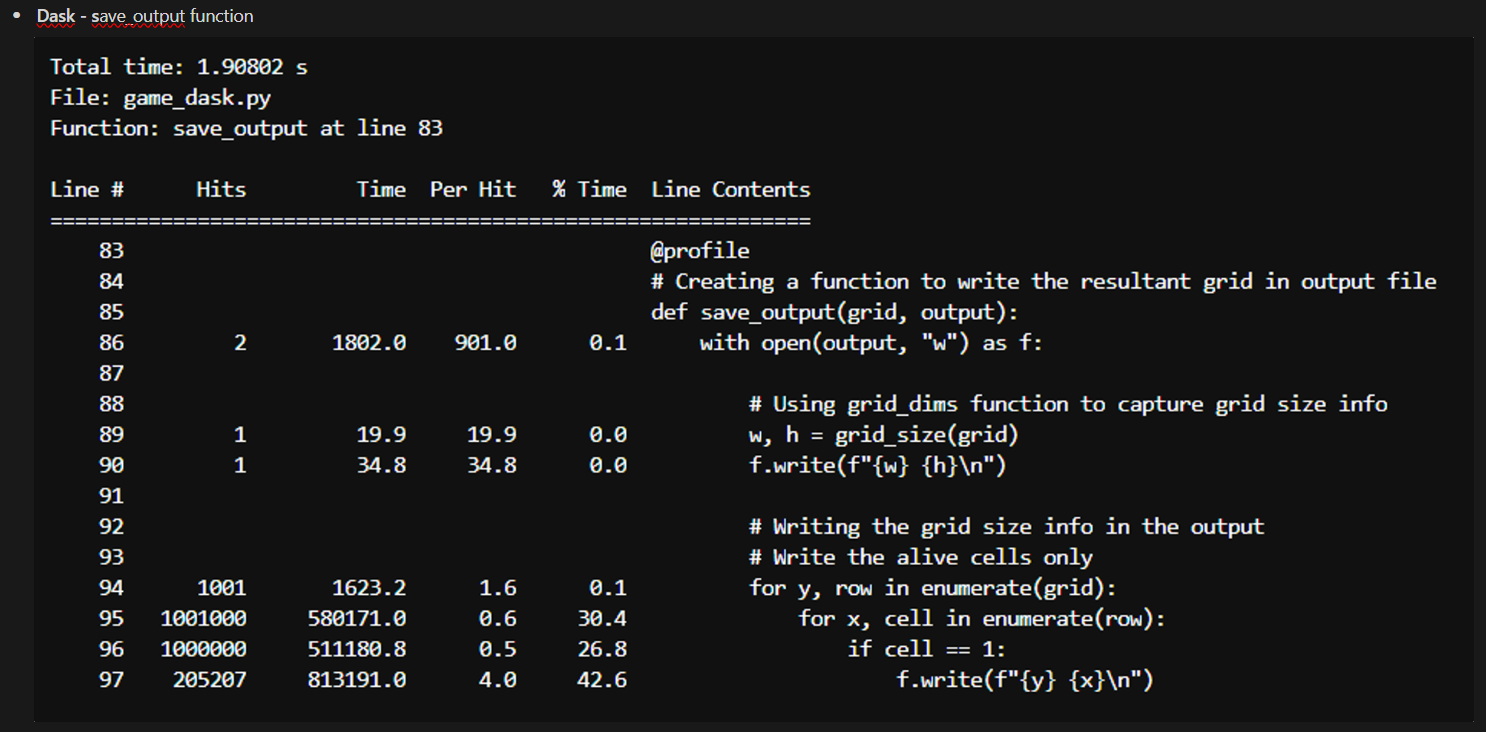

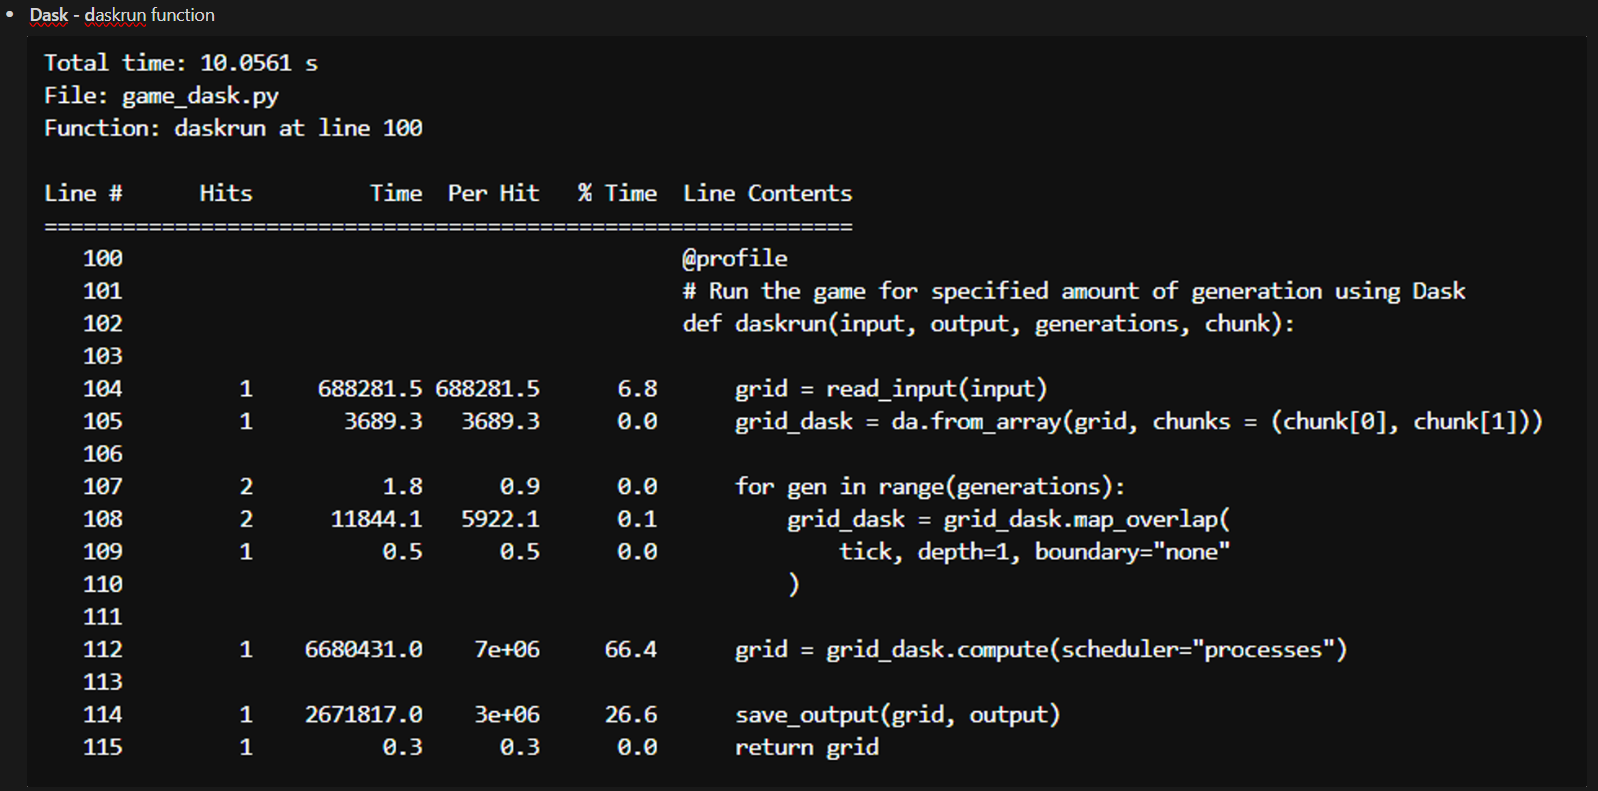

Below are the Line Profiling for each mentioned functions from game_nodask.py.

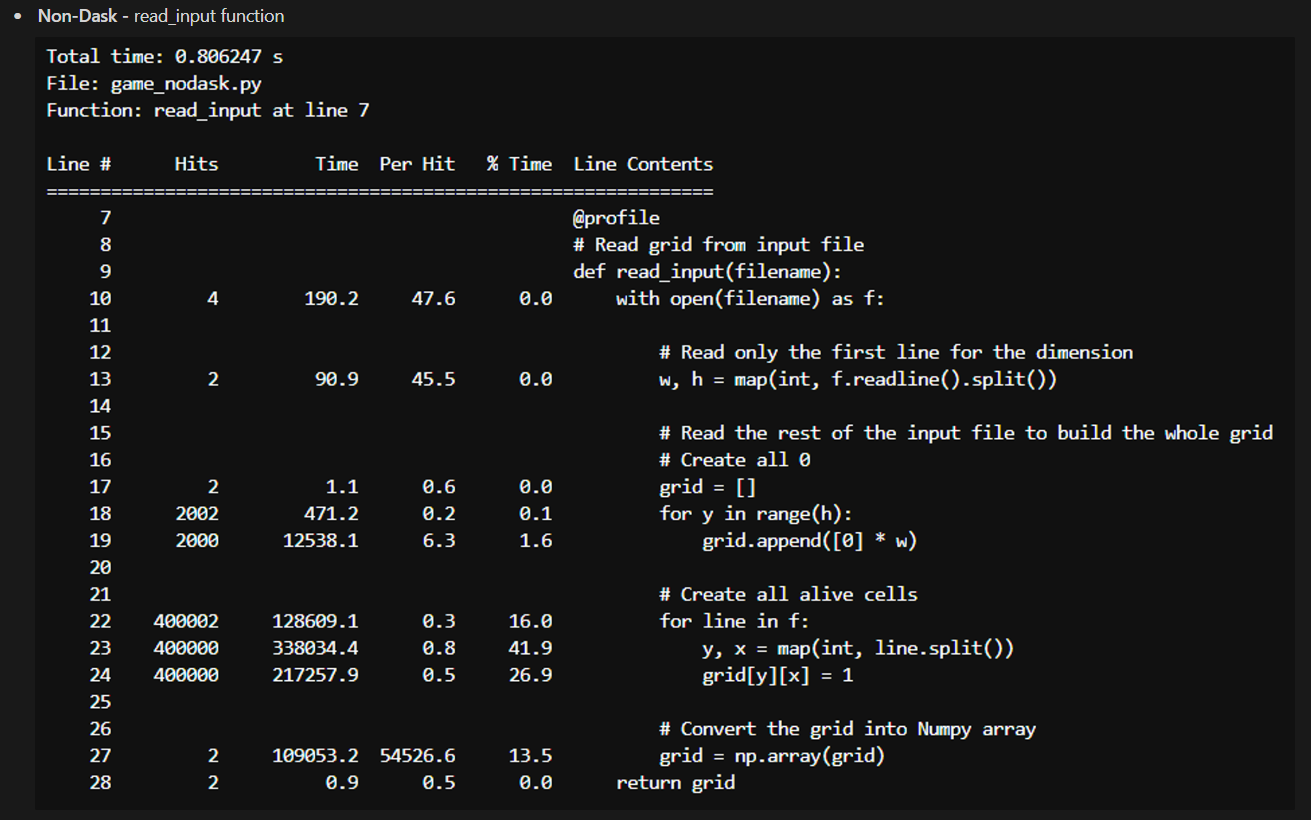

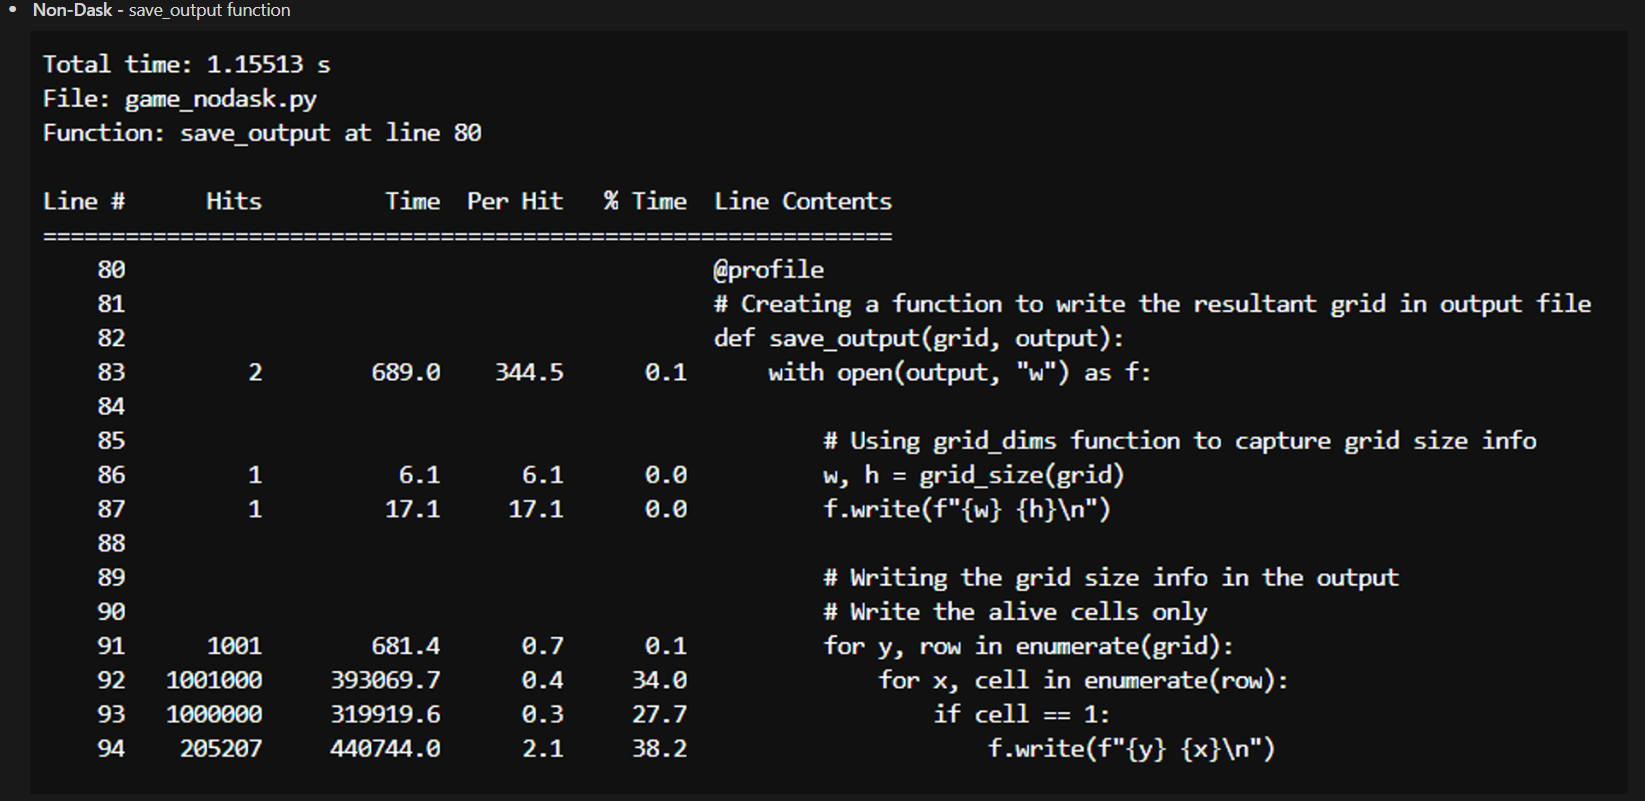

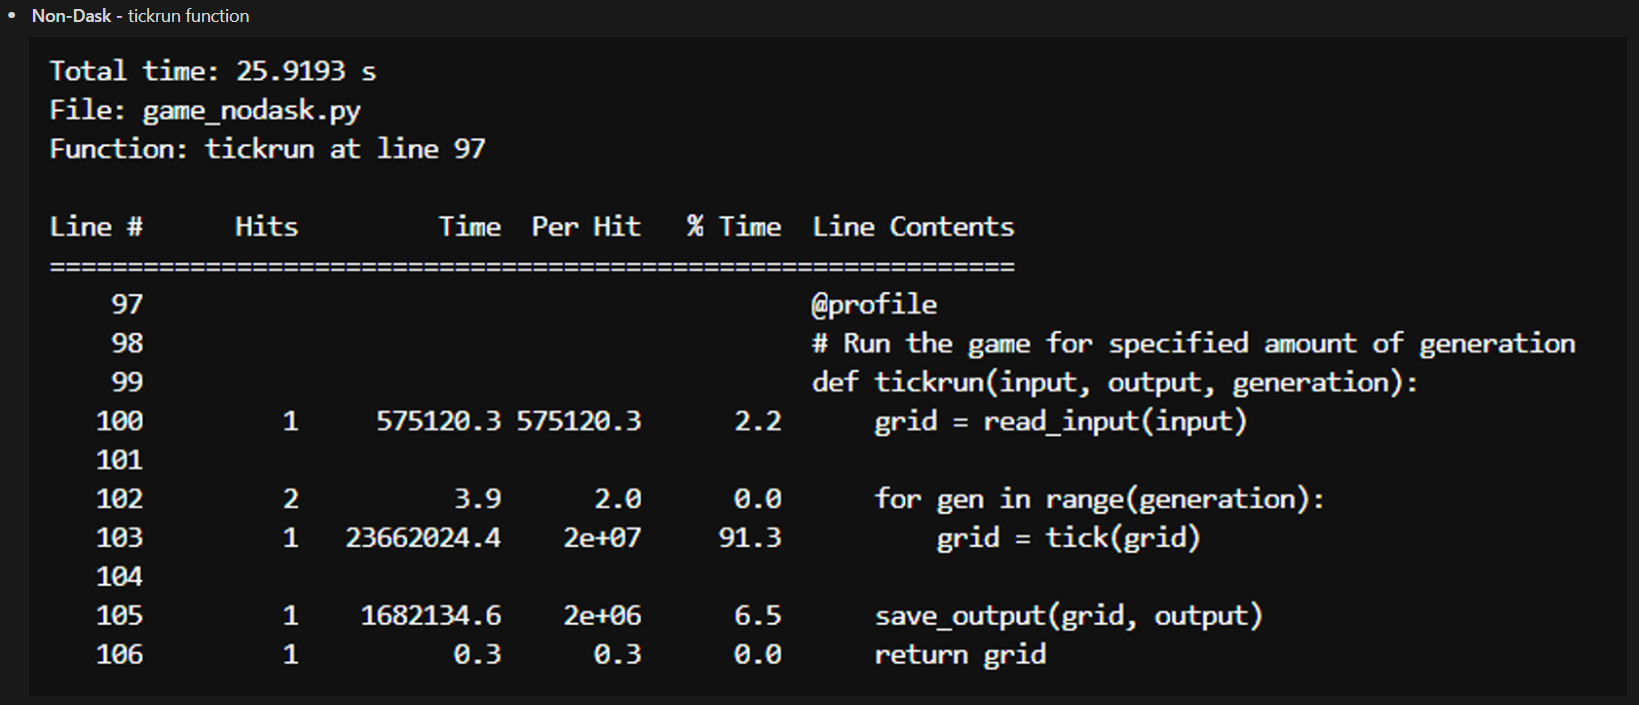

As we can see from read_input and save_output profiles, exactly every line hits the same in both version. This makes sense as both versions use exactly the same codes. But we see that the total time to execute each lines varies.

For read_input and save_output, non-Dask showed faster performance. This is interesting as we might hypothetically think parallel computing will result better time. This might because of Dask overhead introduced to run these functions in parallel actually makes these relatively-simpler tasks to cost more time that they normally are.

For the comparative daskrun and tickrun functions, dask is faster in processing the Game of Life rules. It is interesting to see that in Dask version, we are using dask array’s map.overlay function that is equivalent to a part of code contained in tick(grid) in non-dask version. However, the time gap between there two particular codes is very big. This shows that dask array introduces functions that are very beneficial to reduce time instead of using normal Numpy array. 

It is also interesting to consider that we are testing this for only 1 generation and Dask has additional dask.compute() which we know from previous cProfile as one of the biggest fucntions to run in this code. This example, combined with what we have seen from input and save, shows that parallel computing works better for separating bigger task and might actually perform worse to run simpler tasks.

## Dask Daskboard

We are using Dask Dashboard to create task stream. This visualization helped us to how the code is processed in each thread of the computer core.

Each of the 16 lines are the thread. Each same rectangle represents one task. White spaces are dead time. Red blocks represent communications between tasks in the stream.

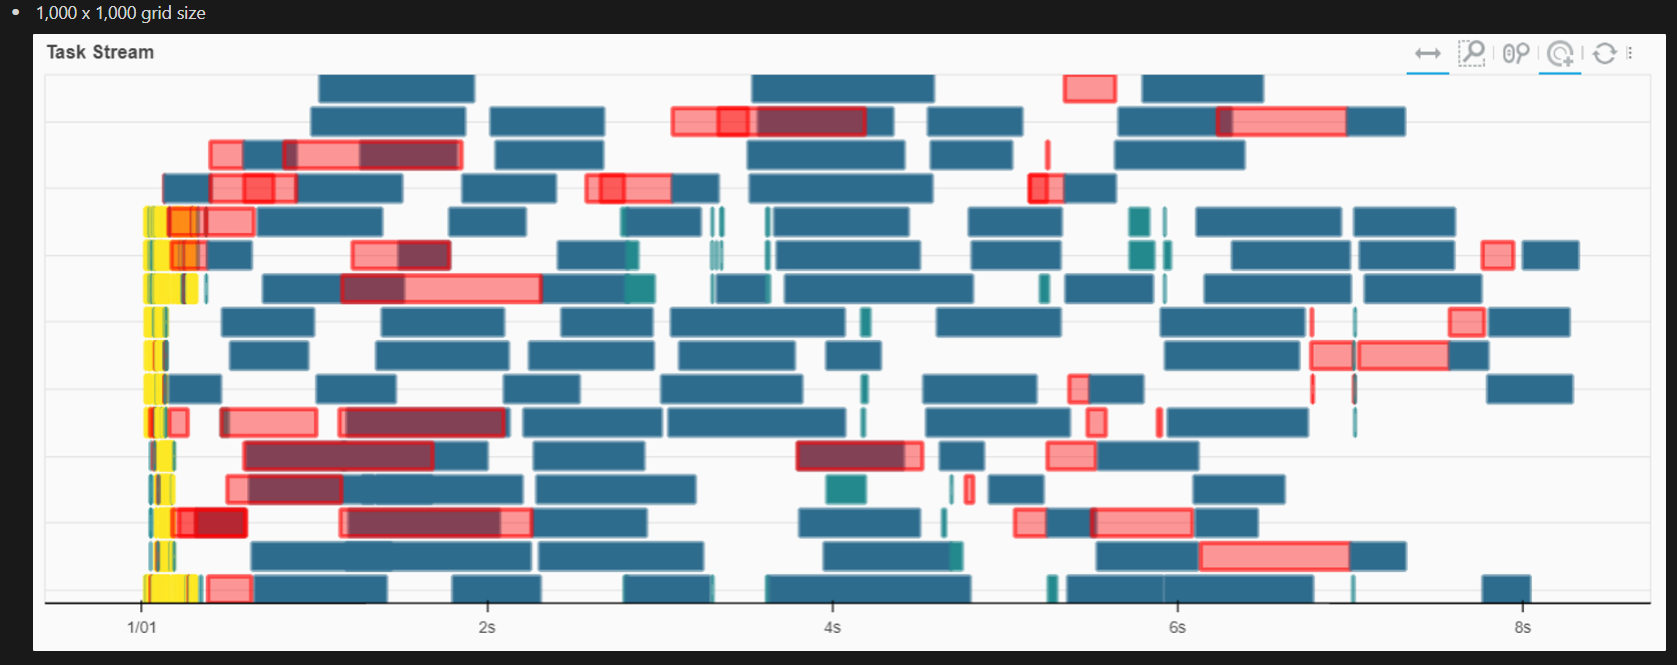

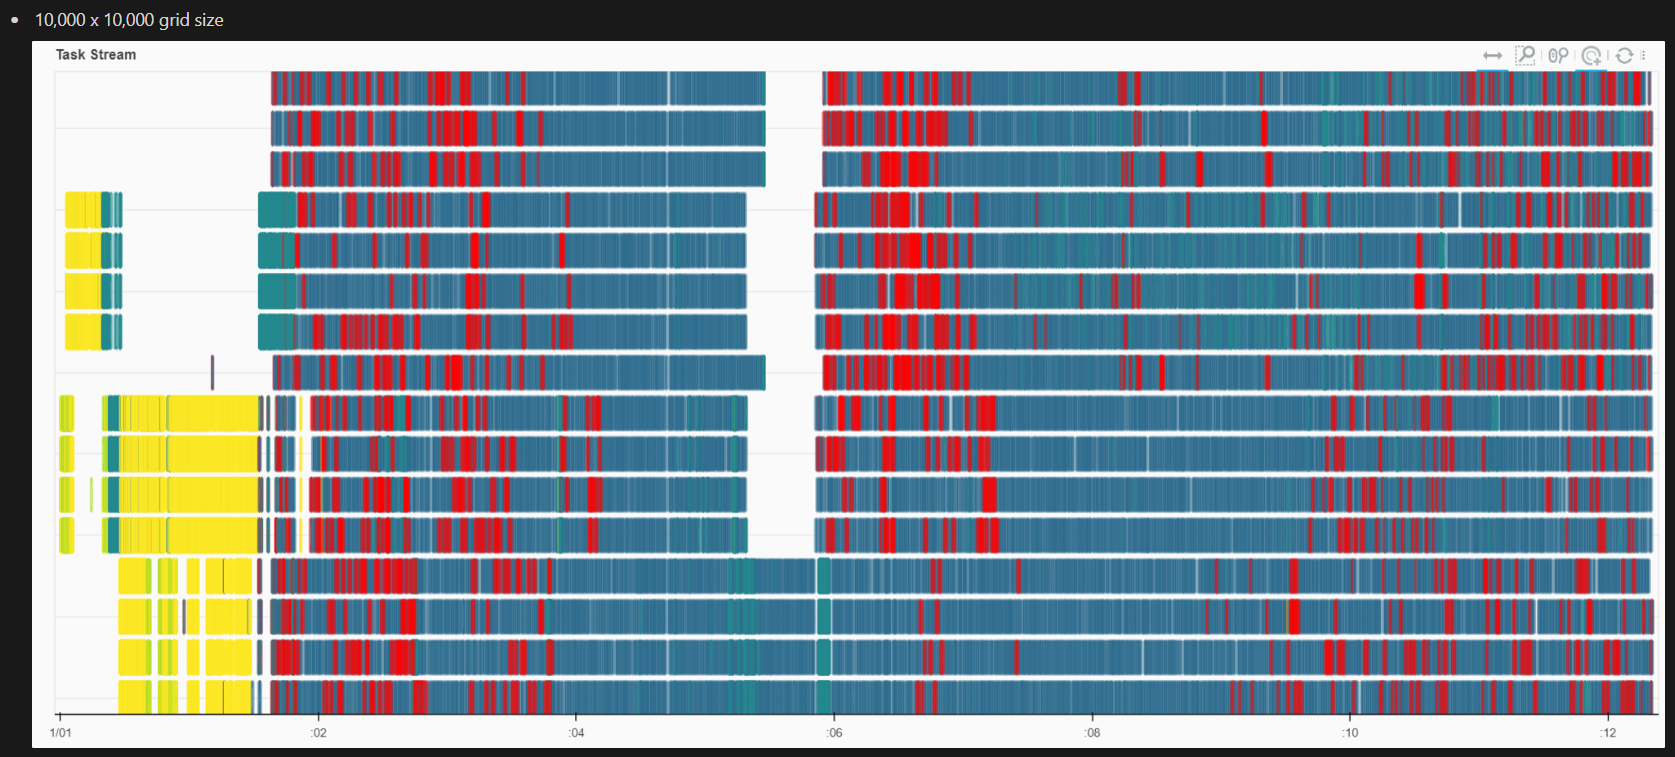

The comparation between 1,000 and 10,000 grids show that the bigger grid size shows busier task processing. Both shows that communication between tasks is positioned in several spots shown in red blocks, but there are patterns that the communication is mostly packed in a particular time. This pattern is shown more clearly in the 10,000 grid size in almost all threads. This shows the advantage of having parallel computing that minimize the need for tasks to communicate and create additional overheads.